In [256]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
from datetime import datetime
import numpy as np

steamdb_dir = 'data/steamdb/'  # read chart-{game}.html files from steamdb.info
out_dir = 'gen/player-counts/' # save graphs here


In [257]:
dfs = dict()
for filename in os.listdir(steamdb_dir):
    f = os.path.join(steamdb_dir, filename)
    if os.path.isfile(f):
        df_name = filename[6:-4] # files manually saved as `chart-game.csv` -> game
        # print(f'Adding df: {df_name}')
        dfs[df_name] = pd.read_csv(f, usecols=['DateTime', 'Players'])

In [258]:
# Clean data, impute Player counts for missing values
for game, df in dfs.items():
    # print(game)
    df.set_index('DateTime')
    # df['Players'] = df['Players'].interpolate(method='linear', inplace=True)
    df.dropna(subset=['Players'], inplace=True)
    # df['Players'] = df['Players'].round()
    df = df.astype({'Players': int})

In [259]:
# get update stats
patch_counts = pd.read_csv('data/patch_counts.csv')
patch_counts['days_since_launch'] = np.zeros(len(patch_counts))-1


/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_94159/1989728666.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


<Figure size 576x432 with 0 Axes>

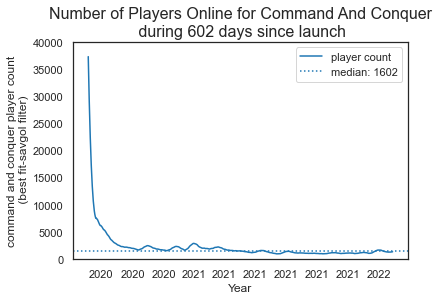

<Figure size 576x432 with 0 Axes>

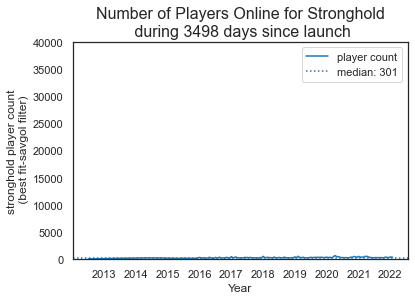

<Figure size 576x432 with 0 Axes>

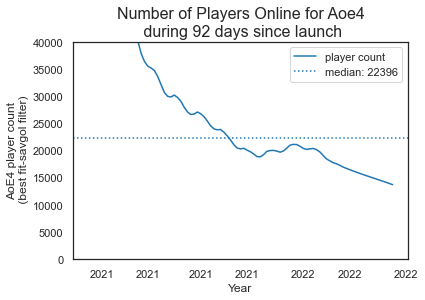

<Figure size 576x432 with 0 Axes>

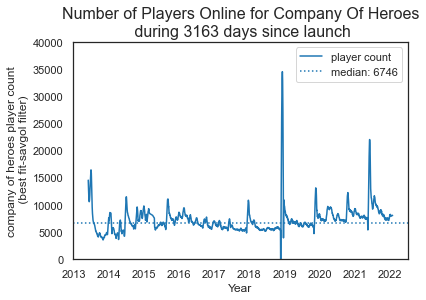

<Figure size 576x432 with 0 Axes>

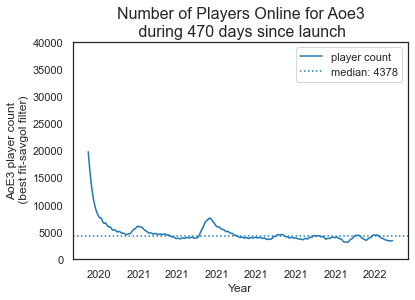

<Figure size 576x432 with 0 Axes>

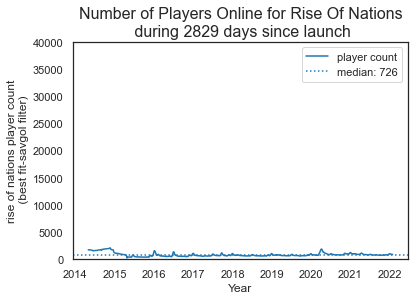

<Figure size 576x432 with 0 Axes>

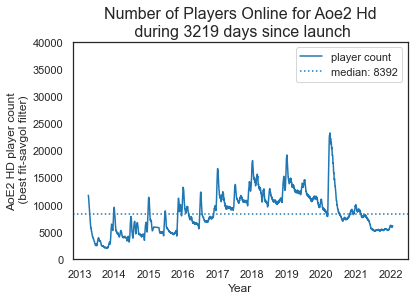

<Figure size 576x432 with 0 Axes>

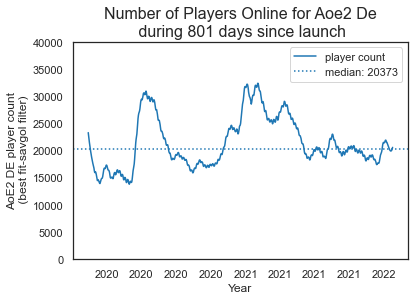

<Figure size 576x432 with 0 Axes>

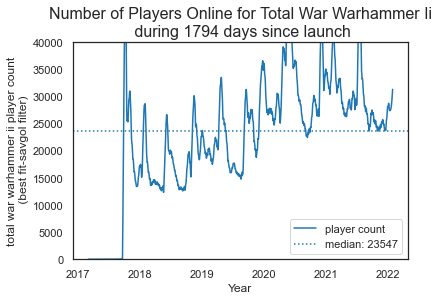

<Figure size 576x432 with 0 Axes>

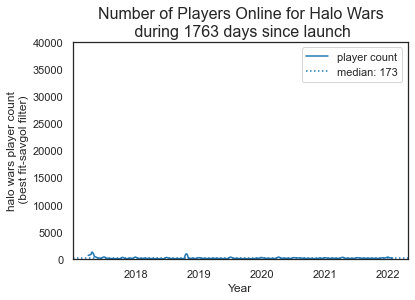

<Figure size 576x432 with 0 Axes>

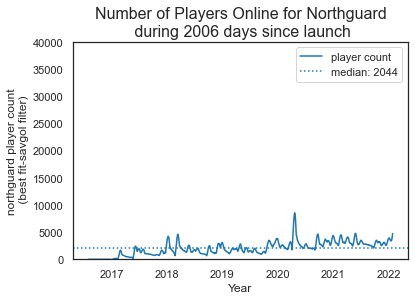

In [260]:
# Plot all games' player counts
# side effect! update days between updates TODO fix
for game, df in dfs.items():
    days = pd.to_datetime(df['DateTime'])
    min_ = datetime.strptime(df.DateTime.min(), "%Y-%m-%d %H:%M:%S")
    max_ = datetime.strptime(df.DateTime.max(), "%Y-%m-%d %H:%M:%S")
    delta = (max_ - min_).days

    # Update how long people have been playing this game and how many players play
    patch_counts.loc[patch_counts['name'] == game,'days_since_launch'] = delta
    median_players = int(round(df.Players.median(),0))
    patch_counts.loc[patch_counts['name'] == game,'median_players'] = median_players

    num_players_filtered = df[['Players']].apply(savgol_filter, window_length=31, polyorder=3)

    plt.figure(figsize=(8,6))
    _, ax = plt.subplots()
    plt.plot(days, num_players_filtered, label='player count')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    # plt.scatter(days, df['Players']) # uncomment if we want actual player values
    plt.ylabel(f'{game.replace("-", " ")} player count\n (best fit-savgol filter)')
    plt.xlabel('Year')
    plt.axhline(median_players, linestyle=":", label=f"median: {median_players}")
    plt.title(f'Number of Players Online for {game.replace("-", " ").title()}\n '
              f'during {delta} days since launch', fontsize=16)
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0,40000])

    plt.savefig(f'{out_dir}{game}.png', bbox_inches='tight')
    # plt.show()


In [261]:
patch_counts # now updated with days_since_launch
patch_counts['days_between_updates'] = patch_counts.days_since_launch/patch_counts.num_updates
# patch_counts.sort_values(by='days_between_updates')
patch_counts.sort_values(by='median_players')

# patch_counts[['name', 'num_updates', 'days_between_updates', 'days_since_launch']].agg(['mean', 'median', 'std'])

,steam_app_id,name,num_updates,days_since_launch,median_players,days_between_updates
1,459220,halo-wars,8,1763.0,173.0,220.375000
8,40950,stronghold,24,3498.0,301.0,145.750000
5,287450,rise-of-nations,17,2829.0,726.0,166.411765
3,1213210,command-and-conquer,6,602.0,1602.0,100.333333
4,466560,northguard,398,2006.0,2044.0,5.040201
0,933110,AoE3,31,470.0,4378.0,15.161290
7,231430,company-of-heroes,211,3163.0,6746.0,14.990521
10,221380,AoE2-HD,79,3219.0,8392.0,40.746835
9,813780,AoE2-DE,40,801.0,20373.0,20.025000
2,1466860,AoE4,7,92.0,22396.0,13.142857


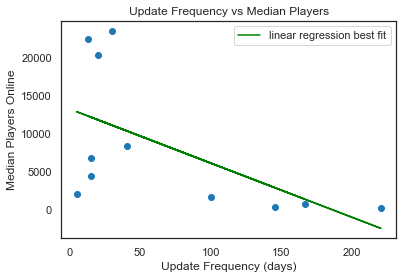

In [262]:
# Plot frequency of updates vs num players per game
plt.scatter(x=patch_counts.days_between_updates, y=patch_counts.median_players)
plt.title('Update Frequency vs Median Players')
plt.xlabel('Update Frequency (days)')
plt.ylabel('Median Players Online')
# Linear regression best fit line https://pythonguides.com/matplotlib-best-fit-line/
dt = np.array(list(zip(patch_counts.days_between_updates, patch_counts.median_players)))
x = dt[:, 0].reshape(dt.shape[0], 1)
X = np.append(x, np.ones((dt.shape[0], 1)), axis=1)
y = dt[:, 1].reshape(dt.shape[0], 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(x, y_line, 'g', label='linear regression best fit')
plt.legend()

plt.savefig(f'{out_dir}frequency-vs-players.png', bbox_inches='tight')
